# Cal-CRAI Index: Climate Hazard Calculations

**Order of operations**:
1) Metric handling \
   1a - Retrieve data \
   1b - Min-max standardization \
   1c - Set hazard risk orientation (positive for when a larger value represents greater vulnerability, negative for when a larger value corresponds to decreased vulnerability)

2) Calculate indicators \
   2a - Isolate exposure and loss columns for all climate risk scenarios \
   2b - Isolate exposure and loss for each individual climate risk scenarios \
   2c - Merge the all climate risk indicator columns with the individual climate risk indicators columns
   
3) Calculate hazard score \
   3a - Exposure * Loss columns \
   3b - Outlier Handling
   
4) Mask out inland counties for Sea Level Rise (SLR) Hazard Column \
   4a - Merge with SLR masking data \
   4b - Any tract not 'SLR impacted' is changed to NaN
   
5) Finalize Hazard Score

6) Visualize, save, and export Climate Hazard Score dataframe

In [2]:
import pandas as pd
import os
import sys
import numpy as np

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_plotting import plot_hazard_score, plot_region_domain # type: ignore
from scripts.utils.cal_crai_calculations import (handle_outliers, min_max_standardize, process_domain_csv_files,  # type: ignore
                                        indicator_dicts, 
                                        add_census_tracts, domain_summary_stats, compute_summed_climate_indicators)

## Metric Handling
### 1a) Retrieve metric files and process

In [3]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


Process and merge climate hazard metric files together

In [4]:
# domain-specific
domain_prefix = 'climate_'
input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within climate_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_climate_metrics.csv


Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
pd.set_option('display.max_columns', None)
cleaned_climate_df = pd.read_csv(merged_output_file)
cleaned_climate_df

,GEOID,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days
0,6001400100,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5
1,6001400200,37.984370,197.583333,7394.25,3.500000,0.570255,2.766667,18.758333,NaN,NaN,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,1.0,434115.0,3.0,0.0,1.0,14.0,775.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
2,6001400300,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2600.0000,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,922941.0,3.0,0.0,1.0,14.0,1941.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
3,6001400400,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,NaN,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,594158.0,3.0,0.0,1.0,14.0,1328.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
4,6001400500,37.984370,197.583333,7394.25,4.250000,0.570255,2.766667,18.758333,NaN,2625.3700,0.0,1.009346,1.275314,1.0,3.0,-3.550000,769.522222,14348.571429,74.250000,1.0,398157.0,3.0,0.0,1.0,14.0,1057.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,38.971624,NaN,NaN,10.000000,0.571168,9.284259,10.201852,0.02,NaN,0.0,0.649380,0.018775,3.0,1.0,-3.433333,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38172.890,-1.183333,22.0,0.0,4.0
9125,6115041001,38.971624,NaN,NaN,10.750000,0.571168,8.808889,9.591389,45.42,NaN,0.0,0.547662,0.082888,3.0,2.0,-3.268750,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-51149.184,-1.777083,22.0,0.0,4.0
9126,6115041002,38.971624,NaN,NaN,10.125000,0.571168,9.257895,9.825877,5.96,NaN,0.0,1.119589,0.337733,3.0,2.0,-3.354167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10727.109,-1.762500,22.0,0.0,5.5
9127,6115041101,38.971624,NaN,NaN,8.333333,0.571168,9.950170,10.663265,0.33,NaN,0.0,2.578545,1.122988,3.0,4.0,-2.929167,31274.729606,394088.020213,273.066667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966470.400,-0.556944,22.0,0.0,8.5


Take a look at the resulting dictionary: We will use this later to refactor certain metrics!

In [6]:
metric_vulnerable_resilient_dict

{'vulnerable': ['drought_coverage_percentage',
  'drought_crop_loss_acres',
  'drought_crop_loss_indemnity_amount',
  'change_in_drought_years',
  'percent_weeks_drought',
  'mean_change_annual_heat_days',
  'mean_change_annual_warm_nights',
  'floodplain_percentage',
  'avg_flood_insurance_payout_per_claim',
  'estimated_flood_crop_loss_cost',
  'precip_99percentile',
  'surface_runoff',
  'total_flood_fatalities',
  'median_flood_warning_days',
  'mean_change_cold_days',
  'heat_crop_loss_acres',
  'heat_crop_loss_indemnity_amount',
  'avg_age_adjust_heat_hospitalizations_per_10000',
  'median_heat_warning_days',
  'slr_vulnerable_building_content_cost',
  'fire_stations_count_diff',
  'hospitals_count_diff',
  'police_stations_count_diff',
  'schools_count_diff',
  'building_exposed_slr_count',
  'slr_vulnerability_delta_percentage_change',
  'slr_vulnerable_wastewater_treatment_count',
  'rcp_4.5__50th_percent_change',
  'burn_area_m2',
  'change_ffwi_days',
  'average_damaged_dest

### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [7]:
# standardizing our df
columns_to_process = [col for col in cleaned_climate_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(cleaned_climate_df, columns_to_process)
min_max_metrics

All standardized columns are within the [0, 1] range (considering tolerance).


,GEOID,drought_coverage_percentage_min,drought_coverage_percentage_max,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min,drought_crop_loss_acres_max,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min,drought_crop_loss_indemnity_amount_max,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min,change_in_drought_years_max,change_in_drought_years_min_max_standardized,percent_weeks_drought_min,percent_weeks_drought_max,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min,mean_change_annual_heat_days_max,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min,mean_change_annual_warm_nights_max,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min,floodplain_percentage_max,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min,avg_flood_insurance_payout_per_claim_max,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min,estimated_flood_crop_loss_cost_max,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min,precip_99percentile_max,precip_99percentile_min_max_standardized,surface_runoff_min,surface_runoff_max,surface_runoff_min_max_standardized,total_flood_fatalities_min,total_flood_fatalities_max,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min,median_flood_warning_days_max,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min,mean_change_cold_days_max,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min,heat_crop_loss_acres_max,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min,heat_crop_loss_indemnity_amount_max,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min,avg_age_adjust_heat_hospitalizations_per_10000_max,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min,median_heat_warning_days_max,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min,slr_vulnerable_building_content_cost_max,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min,fire_stations_count_diff_max,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min,hospitals_count_diff_max,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min,police_stations_count_diff_max,police_stations_count_diff_min_max_standardized,schools_count_diff_min,schools_count_diff_max,schools_count_diff_min_max_standardized,building_exposed_slr_count_min,building_exposed_slr_count_max,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min,slr_vulnerability_delta_percentage_change_max,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min,slr_vulnerable_wastewater_treatment_count_max,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min,rcp_4.5__50th_percent_change_max,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min,burn_area_m2_max,burn_area_m2_min_max_standardized,change_ffwi_days_min,change_ffwi_days_max,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min,average_damaged_destroyed_structures_wildfire_max,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min,average_annual_fatalities_wildfire_max,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min,median_red_flag_warning_days_max,median_red_flag_warning_days_min_max_standardized
0,6001400100,22.007144,55.920036,0.471125,15.0,102431.335813,0.001783,795.0,398630.03359,0.016588,1.0,14.25,0.188679,0.405109,0.832117,0.386752,2.0,19.341667,0.039404,2.591667,30.836111,0.542290,0.0,100.0,NaN,0.0,519998.39,0.010508,0.0,200400000.0,0.0,-1.807552,12.97

Isolate for GEOID and standardized columns exclusively

In [8]:
words = ['GEOID','_standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.endswith(word)].tolist())
min_max_standardized_climate_metrics_df = min_max_metrics[selected_columns]
min_max_standardized_climate_metrics_df.head()

,GEOID,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min_max_standardized,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min_max_standardized,surface_runoff_min_max_standardized,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min_max_standardized,schools_count_diff_min_max_standardized,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min_max_standardized,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min_max_standardized
0,6001400100,0.471125,0.001783,0.016588,0.188679,0.386752,0.039404,0.542290,NaN,0.010508,0.0,0.177512,0.543810,0.05,0.108108,0.693182,0.024148,0.004747,0.034103,0.105263,0.092838,1.0,0.0,0.2,0.933333,0.231188,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.138889
1,6001400200,0.471125,0.001783,0.016588,0.188679,0.386752,0.044210,0.572384,NaN,NaN,0.0,0.177512,0.543810,0.05,0.108108,0.693182,0.024148,0.004747,0.034103,0.000000,0.061995,1.0,0.0,0.2,0.933333,0.136252,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
2,6001400300,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,0.005000,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.131804,1.0,0.0,0.2,0.933333,0.341245,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
3,6001400400,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,NaN,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.084851,1.0,0.0,0.2,0.933333,0.233474,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000
4,6001400500,0.471125,0.001783,0.016588,0.245283,0.386752,0.044210,0.572384,NaN,0.005049,0.0,0.190519,0.545271,0.05,0.108108,0.545455,0.024148,0.004747,0.034103,0.000000,0.056860,1.0,0.0,0.2,0.933333,0.185830,NaN,0.6,0.850374,NaN,0.571429,0.002404,0.0,0.000000


### 1c) Set hazard risk orientation
* High values indicate resiliency to a climate hazard
* Low values indicate vulnerablility to a climate hazard

For the climate domain, all metrics represent a communities vulnerablity to climate hazards rather than resilience. For example, 'median_heat_warning_days' represents a communities vulnerability to extreme heat. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics (in this case all climate metrics) with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [9]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_climate_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_climate_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)
adjusted_vulnerable_df.head()

,GEOID,drought_coverage_percentage_min_max_standardized,drought_crop_loss_acres_min_max_standardized,drought_crop_loss_indemnity_amount_min_max_standardized,change_in_drought_years_min_max_standardized,percent_weeks_drought_min_max_standardized,mean_change_annual_heat_days_min_max_standardized,mean_change_annual_warm_nights_min_max_standardized,floodplain_percentage_min_max_standardized,avg_flood_insurance_payout_per_claim_min_max_standardized,estimated_flood_crop_loss_cost_min_max_standardized,precip_99percentile_min_max_standardized,surface_runoff_min_max_standardized,total_flood_fatalities_min_max_standardized,median_flood_warning_days_min_max_standardized,mean_change_cold_days_min_max_standardized,heat_crop_loss_acres_min_max_standardized,heat_crop_loss_indemnity_amount_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,median_heat_warning_days_min_max_standardized,slr_vulnerable_building_content_cost_min_max_standardized,fire_stations_count_diff_min_max_standardized,hospitals_count_diff_min_max_standardized,police_stations_count_diff_min_max_standardized,schools_count_diff_min_max_standardized,building_exposed_slr_count_min_max_standardized,slr_vulnerability_delta_percentage_change_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min_max_standardized,rcp_4.5__50th_percent_change_min_max_standardized,burn_area_m2_min_max_standardized,change_ffwi_days_min_max_standardized,average_damaged_destroyed_structures_wildfire_min_max_standardized,average_annual_fatalities_wildfire_min_max_standardized,median_red_flag_warning_days_min_max_standardized
0,6001400100,0.528875,0.998217,0.983412,0.811321,0.613248,0.960596,0.457710,NaN,0.989492,1.0,0.822488,0.456190,0.95,0.891892,0.306818,0.975852,0.995253,0.965897,0.894737,0.907162,0.0,1.0,0.8,0.066667,0.768812,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,0.861111
1,6001400200,0.528875,0.998217,0.983412,0.811321,0.613248,0.955790,0.427616,NaN,NaN,1.0,0.822488,0.456190,0.95,0.891892,0.306818,0.975852,0.995253,0.965897,1.000000,0.938005,0.0,1.0,0.8,0.066667,0.863748,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
2,6001400300,0.528875,0.998217,0.983412,0.754717,0.613248,0.955790,0.427616,NaN,0.995000,1.0,0.809481,0.454729,0.95,0.891892,0.454545,0.975852,0.995253,0.965897,1.000000,0.868196,0.0,1.0,0.8,0.066667,0.658755,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
3,6001400400,0.528875,0.998217,0.983412,0.754717,0.613248,0.955790,0.427616,NaN,NaN,1.0,0.809481,0.454729,0.95,0.891892,0.454545,0.975852,0.995253,0.965897,1.000000,0.915149,0.0,1.0,0.8,0.066667,0.766526,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000
4,6001400500,0.528875,0.998217,0.983412,0.754717,0.613248,0.955790,0.427616,NaN,0.994951,1.0,0.809481,0.454729,0.95,0.891892,0.454545,0.975852,0.995253,0.965897,1.000000,0.943140,0.0,1.0,0.8,0.066667,0.814170,NaN,0.4,0.149626,NaN,0.428571,0.997596,1.0,1.000000


## Step 2: Calculate Indicators
Loop to go through df columns and sum metrics that belong within an indicator based off of the metric to indicator dictionary

For the climate domain, metrics are split between 'exposure' and 'loss'

In [10]:
domain_prefix[:-1]

'climate'

### 2a) Isolate exposure and loss columns for all climate risk scenarios

In [11]:
summed_indicators_climate_systems = compute_summed_climate_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
summed_indicators_climate_systems = summed_indicators_climate_systems.rename(columns={'exposure':'all_domain_exposure', 'loss':'all_domain_loss'})
summed_indicators_climate_systems

,GEOID,all_domain_exposure,all_domain_loss
0,6001400100,9.802713,10.312164
1,6001400200,10.137744,9.322672
2,6001400300,9.791870,10.465399
3,6001400400,9.946594,9.470399
4,6001400500,10.022228,10.465350
...,...,...,...
9124,6115040902,8.442814,6.504462
9125,6115041001,7.968531,6.430213
9126,6115041002,8.218612,6.466361
9127,6115041101,7.773482,6.231824


### 2b) Isolate exposure and loss for each individual climate risk scenarios
* create dictionary that separates metric columns by the five climate risks
* create another dictionary that further separates metric columns by exposure or loss
* data are then summed by climate risk and indicator type

In [12]:
standardized_climate_metrics = adjusted_vulnerable_df.copy()

# Remove '_min_max_standardized' suffix from column names
standardized_climate_metrics.columns = adjusted_vulnerable_df.columns.str.replace('_min_max_standardized', '', regex=False)

# Climate risk dictionary to group columns
climate_risk_mapping = {
    'drought': [
        'drought_coverage_percentage',
        'drought_crop_loss_acres',
        'drought_crop_loss_indemnity_amount',
        'change_in_drought_years',
        'percent_weeks_drought'
    ],
    'extreme_heat': [
        'mean_change_annual_heat_days',
        'mean_change_annual_warm_nights',
        'mean_change_cold_days',
        'heat_crop_loss_acres',
        'heat_crop_loss_indemnity_amount',
        'avg_age_adjust_heat_hospitalizations_per_10000',
        'median_heat_warning_days'
    ],
    'inland_flooding': [
        'floodplain_percentage',
        'avg_flood_insurance_payout_per_claim',
        'estimated_flood_crop_loss_cost',
        'precip_99percentile',
        'surface_runoff',
        'total_flood_fatalities',
        'median_flood_warning_days'
    ],
    'sea_level_rise': [
        'slr_vulnerable_building_content_cost',
        'building_exposed_slr_count',
        'slr_vulnerability_delta_percentage_change',
        'slr_vulnerable_wastewater_treatment_count',
        'rcp_4.5__50th_percent_change',
        'fire_stations_count_diff',
        'hospitals_count_diff',
        'police_stations_count_diff',
        'schools_count_diff'
    ],
    'wildfire': [
        'burn_area_m2',
        'change_ffwi_days',
        'average_damaged_destroyed_structures_wildfire',
        'average_annual_fatalities_wildfire',
        'median_red_flag_warning_days'
    ]
}

# Metric dictionary to categorize columns as 'exposure' or 'loss'
metric_to_indicator_climate_dict = {
    "exposure": [
        'drought_coverage_percentage', 'change_in_drought_years', 'percent_weeks_drought',
        'precip_99percentile', 'surface_runoff', 'floodplain_percentage', 'median_flood_warning_days',
        'mean_change_annual_heat_days', 'mean_change_annual_warm_nights', 'median_heat_warning_days',
        'slr_vulnerability_delta_percentage_change', 'slr_fire_stations_count_metric', 'slr_police_stations_count_metric',
        'slr_schools_count_metric', 'slr_hospitals_count_metric', 'slr_vulnerable_wastewater_treatment_count',
        'building_exposed_slr_count', 'slr_vulnerable_building_content_cost', 'change_ffwi_days', 'median_red_flag_warning_days'
    ],
    "loss": [
        'drought_crop_loss_acres', 'drought_crop_loss_indemnity_amount', 'avg_flood_insurance_payout_per_claim',
        'estimated_flood_crop_loss_cost', 'total_flood_fatalities', 'mean_change_cold_days', 'heat_crop_loss_acres',
        'heat_crop_loss_indemnity_amount', 'avg_age_adjust_heat_hospitalizations_per_10000', 'rcp_4.5__50th_percent_change',
        'burn_area_m2', 'average_damaged_destroyed_structures_wildfire', 'average_annual_fatalities_wildfire'
    ]
}

# Step 2: Group and sum the columns by climate risk and metric type
# Initialize an empty DataFrame to hold the summed data
climate_sums_df = pd.DataFrame()
climate_sums_df['GEOID'] = standardized_climate_metrics['GEOID']

# Loop over each climate risk and categorize by exposure/loss
for risk, columns in climate_risk_mapping.items():
    # Separate columns by 'exposure' and 'loss'
    exposure_columns = [col for col in columns if col in metric_to_indicator_climate_dict["exposure"]]
    loss_columns = [col for col in columns if col in metric_to_indicator_climate_dict["loss"]]
    
    # Sum the values for each category and add to the dataframe
    climate_sums_df[f'{risk}_exposure'] = standardized_climate_metrics[exposure_columns].sum(axis=1)
    climate_sums_df[f'{risk}_loss'] = standardized_climate_metrics[loss_columns].sum(axis=1)
    
for risk in climate_risk_mapping.keys():
    # Calculate product of exposure and loss for each climate risk
    # If loss indicator is zero, keep the exposure value instead of multiplying
    climate_sums_df[f'{risk}_hazard_score'] = np.where(
        climate_sums_df[f'{risk}_loss'] == 0,
        climate_sums_df[f'{risk}_exposure'],
        climate_sums_df[f'{risk}_exposure'] * climate_sums_df[f'{risk}_loss']
    )

In [13]:
climate_domain_exposure_loss = climate_sums_df.copy()

# Define the list of columns to exclude
exclude_columns = ['drought_hazard_score', 'extreme_heat_hazard_score', 
                   'inland_flooding_hazard_score', 'sea_level_rise_hazard_score', 
                   'wildfire_hazard_score']

# Drop these columns from the DataFrame
climate_domain_exposure_loss = climate_domain_exposure_loss.drop(columns=exclude_columns, errors='ignore')
climate_domain_exposure_loss.head()

,GEOID,drought_exposure,drought_loss,extreme_heat_exposure,extreme_heat_loss,inland_flooding_exposure,inland_flooding_loss,sea_level_rise_exposure,sea_level_rise_loss,wildfire_exposure,wildfire_loss
0,6001400100,1.953443,1.981629,2.313043,3.243820,2.170570,2.939492,2.075974,0.149626,1.289683,1.997596
1,6001400200,1.953443,1.981629,2.383407,3.243820,2.170570,1.950000,2.201753,0.149626,1.428571,1.997596
2,6001400300,1.896839,1.981629,2.383407,3.391548,2.156101,2.945000,1.926951,0.149626,1.428571,1.997596
3,6001400400,1.896839,1.981629,2.383407,3.391548,2.156101,1.950000,2.081675,0.149626,1.428571,1.997596
4,6001400500,1.896839,1.981629,2.383407,3.391548,2.156101,2.944951,2.157310,0.149626,1.428571,1.997596


### 2c) Merge the all climate risk indicator columns with the individual climate risk indicators columns

In [14]:
# Step 3: Merge the aggregated data back with the original `summed_indicators_climate_systems`
climate_exposure_loss_values = pd.merge(summed_indicators_climate_systems, climate_domain_exposure_loss, on='GEOID', how='left')
climate_exposure_loss_values

,GEOID,all_domain_exposure,all_domain_loss,drought_exposure,drought_loss,extreme_heat_exposure,extreme_heat_loss,inland_flooding_exposure,inland_flooding_loss,sea_level_rise_exposure,sea_level_rise_loss,wildfire_exposure,wildfire_loss
0,6001400100,9.802713,10.312164,1.953443,1.981629,2.313043,3.243820,2.170570,2.939492,2.075974,0.149626,1.289683,1.997596
1,6001400200,10.137744,9.322672,1.953443,1.981629,2.383407,3.243820,2.170570,1.950000,2.201753,0.149626,1.428571,1.997596
2,6001400300,9.791870,10.465399,1.896839,1.981629,2.383407,3.391548,2.156101,2.945000,1.926951,0.149626,1.428571,1.997596
3,6001400400,9.946594,9.470399,1.896839,1.981629,2.383407,3.391548,2.156101,1.950000,2.081675,0.149626,1.428571,1.997596
4,6001400500,10.022228,10.465350,1.896839,1.981629,2.383407,3.391548,2.156101,2.944951,2.157310,0.149626,1.428571,1.997596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,8.442814,6.504462,1.431629,0.000000,2.205253,1.693529,3.458071,1.850000,0.000000,0.000000,1.347861,2.960933
9125,6115041001,7.968531,6.430213,1.375025,0.000000,2.254279,1.618719,2.948237,1.850000,0.000000,0.000000,1.390991,2.961494
9126,6115041002,8.218612,6.466361,1.422195,0.000000,2.220085,1.657544,3.269734,1.850000,0.000000,0.000000,1.306598,2.958817
9127,6115041101,7.773482,6.231824,1.557415,0.000000,2.150517,1.464363,3.013189,1.850000,0.000000,0.000000,1.052361,2.917461


Save Indicator dataframe as a csv

In [15]:
# set-up file for export
indicator_filename = '{}domain_indicators.csv'.format(domain_prefix)
climate_exposure_loss_values.to_csv(indicator_filename, index=False)

## Step 3: Calculate Hazard Score

### 3a) Calculate the hazard score
Hazard score is: exposure * loss columns

In [16]:
climate_hazard_scores_scenarios = climate_sums_df.copy()
# Define the list of columns to exclude
keep_columns = ['GEOID', 'drought_hazard_score', 'extreme_heat_hazard_score', 
                   'inland_flooding_hazard_score', 'sea_level_rise_hazard_score', 
                   'wildfire_hazard_score']

# Drop these columns from the DataFrame
climate_hazard_scores_scenarios = climate_sums_df[keep_columns].copy()
climate_hazard_scores_scenarios

,GEOID,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,6001400100,3.871000,7.503096,6.380375,0.310620,2.576265
1,6001400200,3.871000,7.731342,4.232612,0.329439,2.853709
2,6001400300,3.758833,8.083437,6.349718,0.288322,2.853709
3,6001400400,3.758833,8.083437,4.204397,0.311473,2.853709
4,6001400500,3.758833,8.083437,6.349613,0.322790,2.853709
...,...,...,...,...,...,...
9124,6115040902,1.431629,3.734660,6.397431,0.000000,3.990926
9125,6115041001,1.375025,3.649043,5.454238,0.000000,4.119411
9126,6115041002,1.422195,3.679889,6.049008,0.000000,3.865984
9127,6115041101,1.557415,3.149137,5.574400,0.000000,3.070222


In [17]:
summed_indicators_climate_systems['hazard_score'] = summed_indicators_climate_systems['all_domain_exposure'] * summed_indicators_climate_systems['all_domain_loss']

In [18]:
climate_hazard_scores_cleaned = pd.merge(summed_indicators_climate_systems, climate_hazard_scores_scenarios, on='GEOID', how='left')
climate_hazard_scores_cleaned = climate_hazard_scores_cleaned.drop(columns={'all_domain_exposure', 'all_domain_loss'})
climate_hazard_scores_cleaned

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,6001400100,101.087188,3.871000,7.503096,6.380375,0.310620,2.576265
1,6001400200,94.510863,3.871000,7.731342,4.232612,0.329439,2.853709
2,6001400300,102.475824,3.758833,8.083437,6.349718,0.288322,2.853709
3,6001400400,94.198210,3.758833,8.083437,4.204397,0.311473,2.853709
4,6001400500,104.886130,3.758833,8.083437,6.349613,0.322790,2.853709
...,...,...,...,...,...,...,...
9124,6115040902,54.915960,1.431629,3.734660,6.397431,0.000000,3.990926
9125,6115041001,51.239351,1.375025,3.649043,5.454238,0.000000,4.119411
9126,6115041002,53.144512,1.422195,3.679889,6.049008,0.000000,3.865984
9127,6115041101,48.442971,1.557415,3.149137,5.574400,0.000000,3.070222


### 3b) Outlier Handling
* set fencing for each hazard score at 25th and 75th percentiles
* reset values that exceed the fence to nearest fence value

In [19]:
climate_hazard_scores_outlier_handle = handle_outliers(climate_hazard_scores_cleaned, domain_prefix='climate', summary_stats=True)
climate_hazard_scores_outlier_handle

For column hazard_score:
  Q1 (25th percentile): 49.60636161571717
  Q3 (75th percentile): 77.92413480780718
  IQR: 28.31777319209001
  Max fence: 233.77240442342153
  Min fence: -148.81908484715152
For column drought_hazard_score:
  Q1 (25th percentile): 1.2328953894451224
  Q3 (75th percentile): 2.255397973206795
  IQR: 1.0225025837616726
  Max fence: 6.766193919620385
  Min fence: -3.6986861683353673
For column extreme_heat_hazard_score:
  Q1 (25th percentile): 3.847837547577067
  Q3 (75th percentile): 7.602700340839684
  IQR: 3.754862793262617
  Max fence: 22.808101022519054
  Min fence: -11.543512642731201
For column inland_flooding_hazard_score:
  Q1 (25th percentile): 3.60692479507707
  Q3 (75th percentile): 6.515986258435872
  IQR: 2.9090614633588014
  Max fence: 19.547958775307613
  Min fence: -10.82077438523121
For column sea_level_rise_hazard_score:
  Q1 (25th percentile): 0.0
  Q3 (75th percentile): 0.33949521457239895
  IQR: 0.33949521457239895
  Max fence: 1.0184856437171

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,6001400100,101.087188,3.871000,7.503096,6.380375,0.310620,2.576265
1,6001400200,94.510863,3.871000,7.731342,4.232612,0.329439,2.853709
2,6001400300,102.475824,3.758833,8.083437,6.349718,0.288322,2.853709
3,6001400400,94.198210,3.758833,8.083437,4.204397,0.311473,2.853709
4,6001400500,104.886130,3.758833,8.083437,6.349613,0.322790,2.853709
...,...,...,...,...,...,...,...
9124,6115040902,54.915960,1.431629,3.734660,6.397431,0.000000,3.990926
9125,6115041001,51.239351,1.375025,3.649043,5.454238,0.000000,4.119411
9126,6115041002,53.144512,1.422195,3.679889,6.049008,0.000000,3.865984
9127,6115041101,48.442971,1.557415,3.149137,5.574400,0.000000,3.070222


### 3c) Min-max standardize the product columns

In [20]:
columns_to_process = ['hazard_score'
                      ,'drought_hazard_score'
                      ,'extreme_heat_hazard_score'
                      ,'inland_flooding_hazard_score'
                      ,'sea_level_rise_hazard_score'
                      ,'wildfire_hazard_score']

min_max_domain = min_max_standardize(climate_hazard_scores_outlier_handle, columns_to_process)
min_max_domain

All standardized columns are within the [0, 1] range (considering tolerance).


,GEOID,hazard_score_min,hazard_score_max,hazard_score_min_max_standardized,drought_hazard_score_min,drought_hazard_score_max,drought_hazard_score_min_max_standardized,extreme_heat_hazard_score_min,extreme_heat_hazard_score_max,extreme_heat_hazard_score_min_max_standardized,inland_flooding_hazard_score_min,inland_flooding_hazard_score_max,inland_flooding_hazard_score_min_max_standardized,sea_level_rise_hazard_score_min,sea_level_rise_hazard_score_max,sea_level_rise_hazard_score_min_max_standardized,wildfire_hazard_score_min,wildfire_hazard_score_max,wildfire_hazard_score_min_max_standardized
0,6001400100,0.0,134.126396,0.753671,0.0,4.40772,0.878232,0.0,9.756507,0.769035,0.0,10.332432,0.617510,0.0,1.018486,0.304982,0.0,4.714666,0.546436
1,6001400200,0.0,134.126396,0.704640,0.0,4.40772,0.878232,0.0,9.756507,0.792429,0.0,10.332432,0.409643,0.0,1.018486,0.323460,0.0,4.714666,0.605283
2,6001400300,0.0,134.126396,0.764024,0.0,4.40772,0.852784,0.0,9.756507,0.828517,0.0,10.332432,0.614542,0.0,1.018486,0.283089,0.0,4.714666,0.605283
3,6001400400,0.0,134.126396,0.702309,0.0,4.40772,0.852784,0.0,9.756507,0.828517,0.0,10.332432,0.406913,0.0,1.018486,0.305819,0.0,4.714666,0.605283
4,6001400500,0.0,134.126396,0.781995,0.0,4.40772,0.852784,0.0,9.756507,0.828517,0.0,10.332432,0.614532,0.0,1.018486,0.316931,0.0,4.714666,0.605283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.0,134.126396,0.409434,0.0,4.40772,0.324800,0.0,9.756507,0.382787,0.0,10.332432,0.619160,0.0,1.018486,0.000000,0.0,4.714666,0.846492
9125,6115041001,0.0,134.126396,0.382023,0.0,4.40772,0.311958,0.0,9.756507,0.374011,0.0,10.332432,0.527876,0.0,1.018486,0.000000,0.0,4.714666,0.873744
9126,6115041002,0.0,134.126396,0.396227,0.0,4.40772,0.322660,0.0,9.756507,0.377173,0.0,10.332432,0.585439,0.0,1.018486,0.000000,0.0,4.714666,0.819991
9127,6115041101,0.0,134.126396,0.361174,0.0,4.40772,0.353338,0.0,9.756507,0.322773,0.0,10.332432,0.539505,0.0,1.018486,0.000000,0.0,4.714666,0.651207


Isolate to census tract and product standardized columns
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [21]:
keep_columns = ['GEOID', 
                'hazard_score_min_max_standardized'
                ,'drought_hazard_score_min_max_standardized'
                ,'extreme_heat_hazard_score_min_max_standardized'
                ,'inland_flooding_hazard_score_min_max_standardized'
                ,'sea_level_rise_hazard_score_min_max_standardized'
                ,'wildfire_hazard_score_min_max_standardized'
]

climate_hazard_scores = min_max_domain[keep_columns].copy()

# Rename columns by removing '_min_max_standardized' suffix
climate_hazard_scores.columns = climate_hazard_scores.columns.str.replace('_min_max_standardized', '', regex=False)
climate_hazard_scores

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,6001400100,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436
1,6001400200,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283
2,6001400300,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283
3,6001400400,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283
4,6001400500,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283
...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.619160,0.000000,0.846492
9125,6115041001,0.382023,0.311958,0.374011,0.527876,0.000000,0.873744
9126,6115041002,0.396227,0.322660,0.377173,0.585439,0.000000,0.819991
9127,6115041101,0.361174,0.353338,0.322773,0.539505,0.000000,0.651207


## Step 4) Mask out inland counties for Sea Level Rise (SLR) Hazard Column

In [22]:
slr_mask_data = '../utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})
slr_mask.head()

,GEOID,slr_impacted
0,6085504321,1
1,6085504410,1
2,6085507003,1
3,6085507004,1
4,6085502204,1


### 4a) Merge with SLR masking data

In [23]:
climate_hazard_scores['GEOID'] = climate_hazard_scores['GEOID'].astype(str)
slr_mask['GEOID'] = slr_mask['GEOID'].astype(str)

climate_hazard_scores_slr_masked = pd.merge(climate_hazard_scores, slr_mask, on='GEOID', how='left')
climate_hazard_scores_slr_masked

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score,slr_impacted
0,6001400100,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436,1
1,6001400200,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283,1
2,6001400300,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283,1
3,6001400400,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283,1
4,6001400500,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283,1
...,...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.619160,0.000000,0.846492,0
9125,6115041001,0.382023,0.311958,0.374011,0.527876,0.000000,0.873744,0
9126,6115041002,0.396227,0.322660,0.377173,0.585439,0.000000,0.819991,0
9127,6115041101,0.361174,0.353338,0.322773,0.539505,0.000000,0.651207,0


### 4b) Any tract not 'SLR impacted' is changed to NaN

In [24]:
climate_hazard_scores_slr_masked.loc[climate_hazard_scores_slr_masked['slr_impacted'] == 0, 'sea_level_rise_hazard_score'] = np.nan
climate_hazard_scores_slr_masked = climate_hazard_scores_slr_masked.drop(columns='slr_impacted')
climate_hazard_scores_slr_masked.head()

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,6001400100,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436
1,6001400200,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283
2,6001400300,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283
3,6001400400,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283
4,6001400500,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283


## Step 5) Finalize Hazard Score
* Add beginning 0's to GEOID column

In [25]:
climate_hazard_scores_final = climate_hazard_scores_slr_masked.copy()

# GEOID handling
climate_hazard_scores_final['GEOID'] = climate_hazard_scores_final['GEOID'].apply(lambda x: '0' + str(x))
climate_hazard_scores_final['GEOID'] = climate_hazard_scores_final['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

In [26]:
climate_hazard_scores_final

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,06001400100,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436
1,06001400200,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283
2,06001400300,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283
3,06001400400,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283
4,06001400500,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283
...,...,...,...,...,...,...,...
9124,06115040902,0.409434,0.324800,0.382787,0.619160,NaN,0.846492
9125,06115041001,0.382023,0.311958,0.374011,0.527876,NaN,0.873744
9126,06115041002,0.396227,0.322660,0.377173,0.585439,NaN,0.819991
9127,06115041101,0.361174,0.353338,0.322773,0.539505,NaN,0.651207


## Step 6) Visualize, save, and export Climate Hazard Score dataframe

Let's look at some summary statistics for this domain:

In [27]:
domain_summary_stats(climate_hazard_scores_final, 'hazard_score')

Median hazard_score domain value: 0.45115207137681224
Mean hazard_score domain value: 0.4833410607900797


Map all of the climate risk scenarios hazard scores
* these are the denominators that go into each weighted scenario
* values will be subtracted from 1 to indicate high values are high hazard

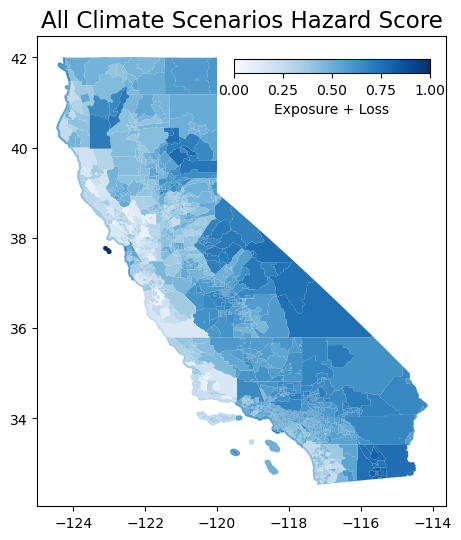

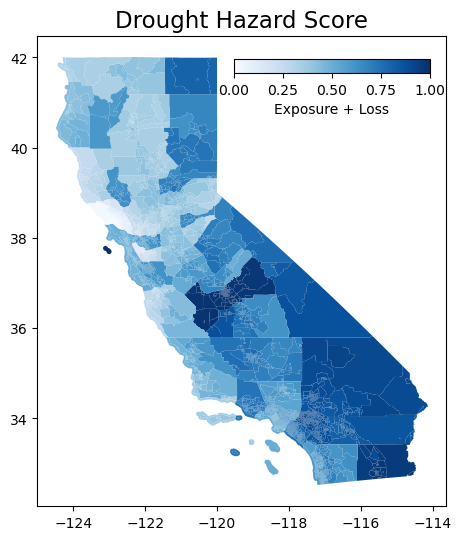

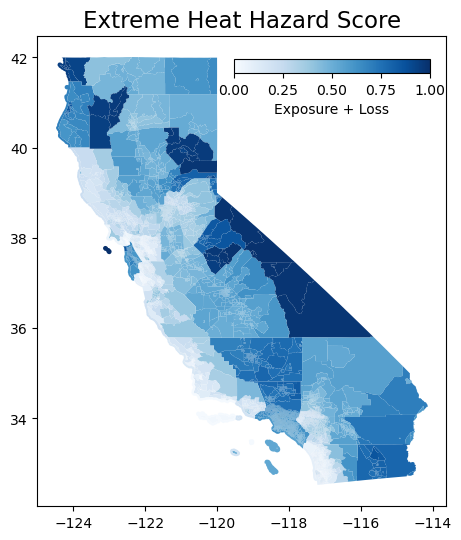

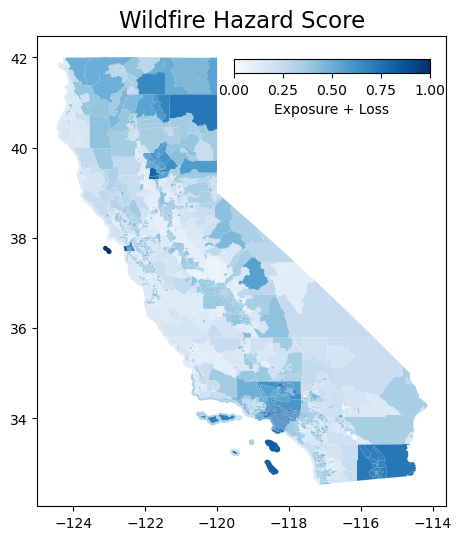

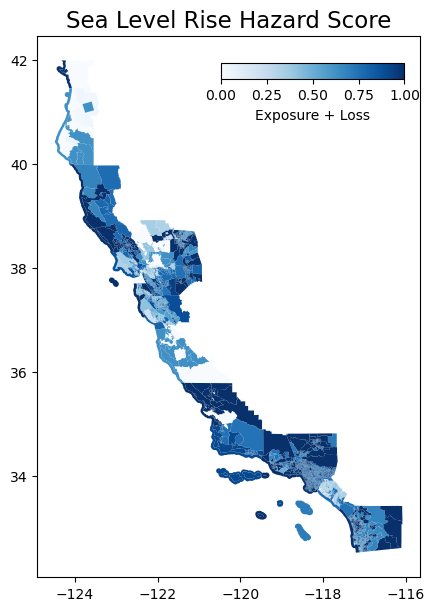

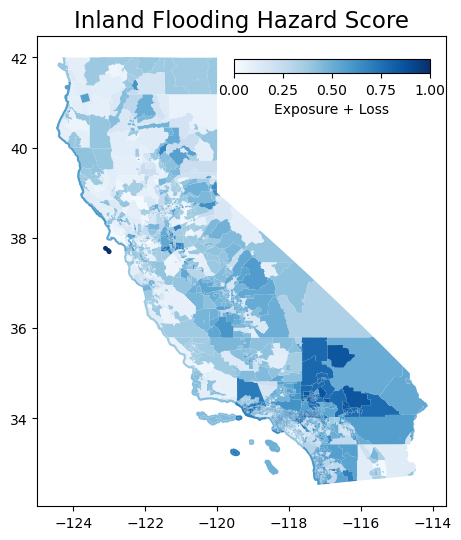

In [28]:
# Copy the dataset
flipped_climate_scenarios = climate_hazard_scores_final.copy()

# List of climate domain columns to process
climate_domain_columns = [
    'hazard_score',
    'drought_hazard_score',
    'extreme_heat_hazard_score',
    'wildfire_hazard_score',
    'sea_level_rise_hazard_score',
    'inland_flooding_hazard_score'
]

# Process each column in the list
for column in climate_domain_columns:
    # Subtract 1 from the column values
    flipped_climate_scenarios[column] = 1 - flipped_climate_scenarios[column]
    
     # Get domain name for plotting
    if column == 'hazard_score':
        domain_name = 'All Climate Scenarios'
    else:
        domain_name = column.split('_hazard_score')[0]  # Extract everything before '_hazard_score'
        domain_name = domain_name.replace('_', ' ').title()
    
    # Call the plotting function
    plot_hazard_score(flipped_climate_scenarios, column_to_plot=column, domain=domain_name)

## Step 7) Export the final domain csv file

In [29]:
# set-up file for export
climate_hazard_scores_filename = 'climate_hazard_scores.csv'
climate_hazard_scores_final.to_csv(climate_hazard_scores_filename, index=False)

Upload the indicator and hazard score csv files to AWS

In [30]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, climate_hazard_scores_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

climate_domain_indicators.csv uploaded to AWS
climate_hazard_scores.csv uploaded to AWS


## Delete desired csv files
* all that were generated from this notebook by default

In [31]:
folders_to_delete = ["aws_csvs", "climate_folder"]
csv_files_to_delete = ["concatenate_climate_metrics.csv", "climate_hazard_scores.csv",
                       "climate_domain_indicators.csv"]

delete_items(folders_to_delete, csv_files_to_delete)

Deleted folder: aws_csvs
Deleted folder: climate_folder
Deleted file: concatenate_climate_metrics.csv
Deleted file: climate_hazard_scores.csv
Deleted file: climate_domain_indicators.csv
